In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the names
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(words)

32033

In [5]:
# Build vocabulary of chars to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {ch:i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i+1:ch for i, ch in enumerate(chars)}
itos[0] = '.'
vocab_size = len(stoi.keys())


In [92]:
block_size = 3  # Context lents: How many chars will be used to predict the next one
# Build the dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append for the next char

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [93]:
# Setup MLP
n_embed = 10
n_hidden = 200
C = torch.randn((vocab_size, n_embed)           )
W1 = torch.randn((n_embed*block_size, n_hidden) ) * (5/3)/((n_embed*block_size) ** 0.5)
#b1 = torch.randn(n_hidden                       ) * 0.01
W2 = torch.randn((n_hidden, vocab_size)         ) * 0.01
b2 = torch.randn(vocab_size                     ) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
lossi = []

params = [C, W1, W2, b2, bngain, bnbias]
sum(p.nelement() for p in params)
for p in params:
    p.requires_grad = True

In [99]:
max_steps = 20000
batch_size = 1024


for i in range(max_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1

    # Normalize batch
    mean = hpreact.mean(0, keepdim=True)
    std = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - mean) / std + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * mean
        bnstd_running = 0.999 * bnstd_running + 0.001 * std


    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update weights
    lr = 0.01 if i < 10000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    # Track loss
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  20000: 2.1935
  10000/  20000: 2.2437


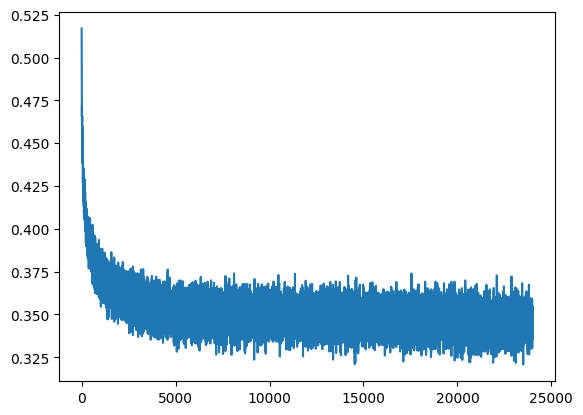

In [100]:
plt.plot(lossi)

In [90]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [101]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = torch.tanh(embcat @ W1 + b1)

    # Normalize batch
    mean = hpreact.mean(0, keepdim=True)
    std = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 2.5495638847351074
val 2.5545477867126465


In [85]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        embcat = emb.view(-1)
        hpreact = torch.tanh(embcat @ W1 + b1)

        # Normalize batch
        mean = hpreact.mean(0, keepdim=True)
        std = hpreact.std(0, keepdim=True)
        hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias

        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

are.
a.
ata.
teria.
lol.
toous.
aar.
aarae.
dela.
cayla.
onia.
orae.
.
aareney.
ael.
aivaan.
anika.
.
ri.
hena.
